# Importing the Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# !pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
# nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Reading the Dataset

In [3]:
df_true = pd.read_csv(r"C:\Users\Checkout\Desktop\SJSU\sem2\ISE244\assignments\project\git-copy\dataset\True.csv")
df_fake = pd.read_csv(r"C:\Users\Checkout\Desktop\SJSU\sem2\ISE244\assignments\project\git-copy\dataset\Fake.csv")

**Setting up a target variable and combining both the real and fake news datasets**

In [4]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

**Lets take a note of the null values in the data**

In [5]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# Data Cleaning

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [7]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# Exploratory Data Analysis

# What is the distribution of Subjects between the True and Fake News? 

In [8]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
display(sub_tf_df)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400,width = 500)
fig.show()

target  Counts
0  False   23481
1   True   21417

In [9]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
display(sub_check)
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.update_layout(width=800, height=600)

fig.show()

subject  Counts
0  Government News    1570
1      Middle-east     778
2             News    9050
3     PoliticsNews   18113
4          US_News     783
5        left-news    4459
6        worldnews   10145

**Observations** Political News and World News hold the most domination counts in the data set that we have considered.

# Can the News Headline be enough to predict if the news if fake or not? Lets us see in the following analysis

In [10]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [11]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

# Lets Take a look at the Word Clouds for the Titles

# Word Cloud using the Real News Headlines

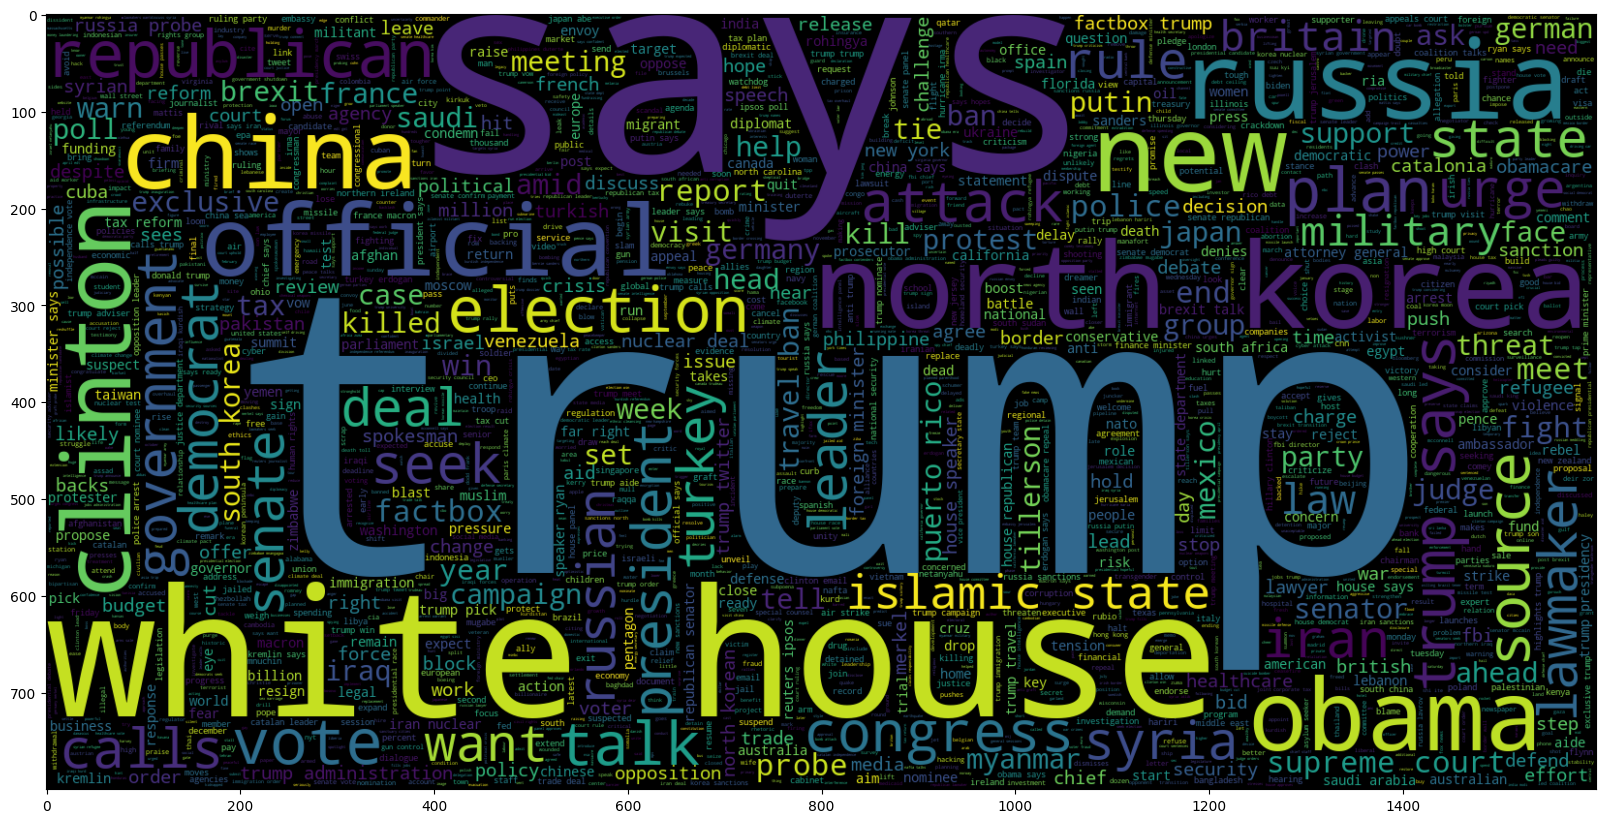

In [12]:
plt.figure(figsize = (20,20)) 
wc_r = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc_r, interpolation = 'bilinear')

In [13]:
print("Top words in Real News Headline: ",list(wc_r.words_.keys())[:10])

Top words in Real News Headline:  ['trump', 'says', 'white house', 'north korea', 'russia', 'new', 'china', 'obama', 'official', 'clinton']


# Word Cloud using the Fake News Headlines


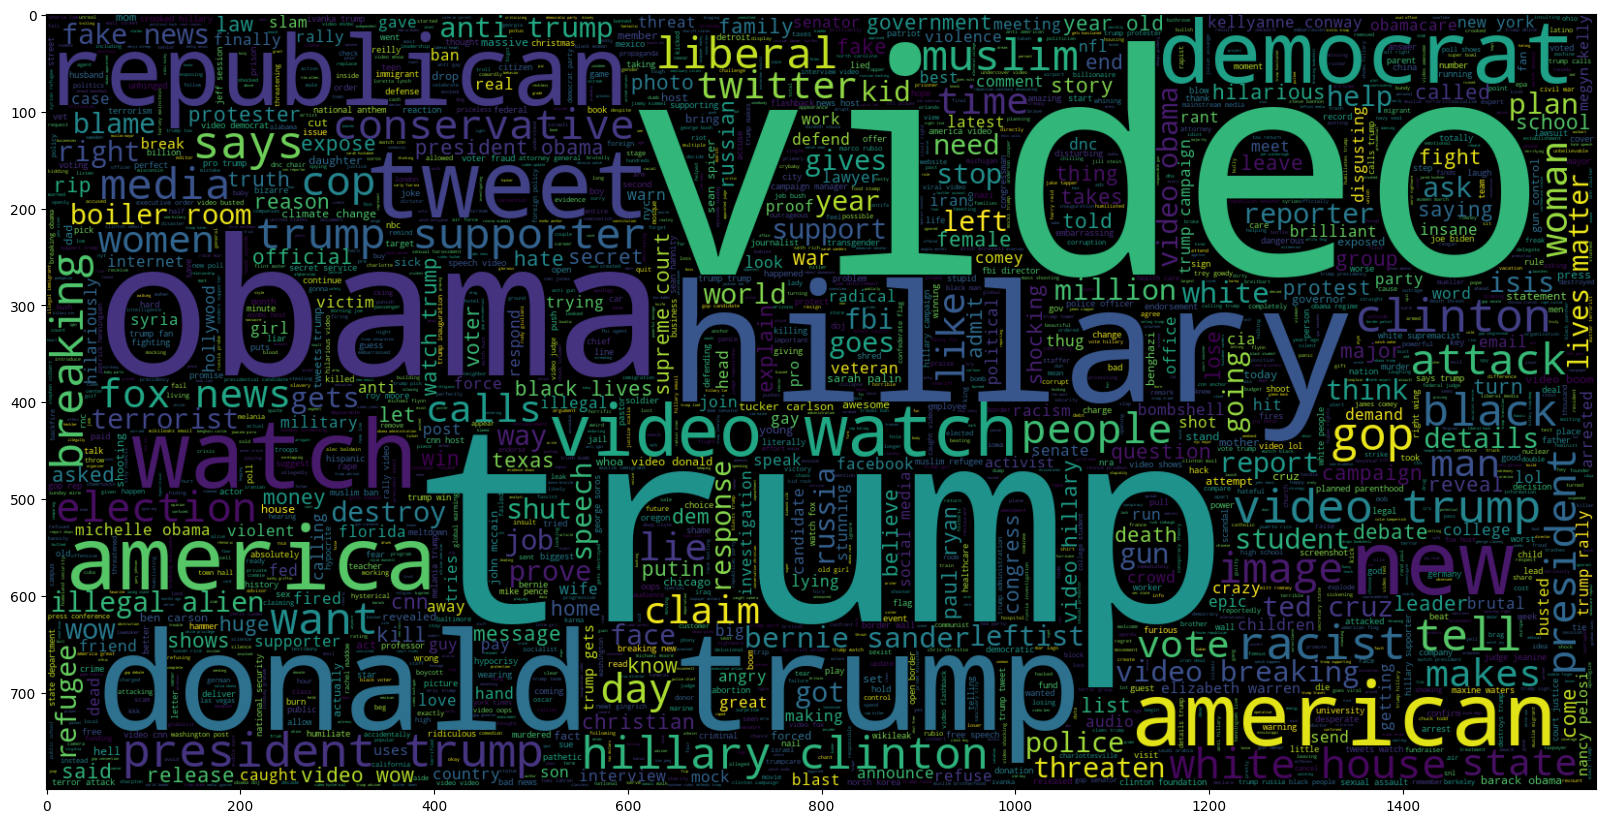

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

In [15]:
print("Top words in Fake News Headline: ",list(wc.words_.keys())[:10])

Top words in Fake News Headline:  ['video', 'trump', 'obama', 'hillary', 'donald trump', 'republican', 'tweet', 'watch', 'new', 'american']


# Lets Look at the Count of Words Distribution in the Title

In [18]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title of news is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50, height= 500,width = 600)

fig.show()

The maximum number of words in a title of news is = 34


In [19]:
maxlen = -1
for doc in df[df.target == 0].clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title of fake news is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df[df.target == 0].clean_joined_title], nbins = 50, height= 500,width = 600)

fig.show()

The maximum number of words in a title of fake news is = 34


# Which Subjects have received the most News Coverage?

In [20]:
maxlen = -1
for doc in df[df.target == 1].clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title of real news is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df[df.target == 1].clean_joined_title], nbins = 50, height= 500,width = 600)

fig.show()

The maximum number of words in a title of real news is = 14


Average length of Original Text:  52.68058084699071
Average length of Fake Text:  69.73846940079213


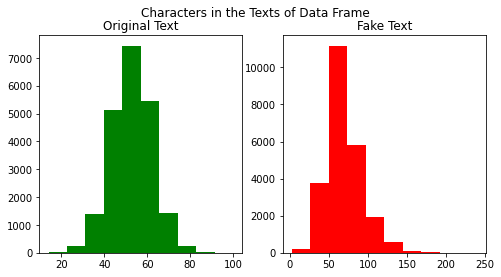

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

text_len = df[df["target"] == 1]["clean_joined_title"].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Original Text')
print("Average length of Original Text: ",text_len.mean())

text_len = df[df["target"] == 0]["clean_joined_title"].str.len()
ax2.hist(text_len, color="red")
ax2.set_title("Fake Text")
print("Average length of Fake Text: ",text_len.mean())

fig.suptitle("Characters in the Texts of Data Frame")
plt.show();

In [22]:
def get_ngrams(corpus, n, g):
    vector = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

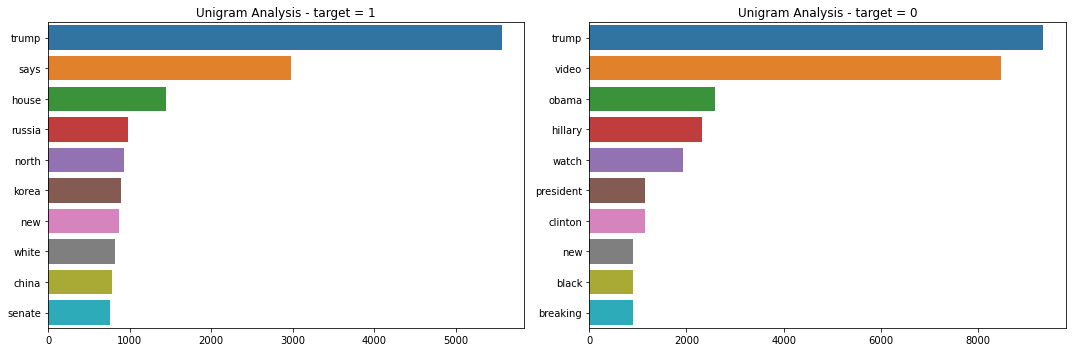

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
most_common_unigram_1 = dict(get_ngrams(df[df['target'] == 1]["clean_joined_title"], 10, 1))
sns.barplot(x=list(most_common_unigram_1.values()), y=list(most_common_unigram_1.keys()))
plt.title("Unigram Analysis - target = 1")

plt.subplot(1, 2, 2)
most_common_unigram_0 = dict(get_ngrams(df[df['target'] == 0]["clean_joined_title"], 10, 1))
sns.barplot(x=list(most_common_unigram_0.values()), y=list(most_common_unigram_0.keys()))
plt.title("Unigram Analysis - target = 0")

plt.tight_layout()
plt.show()

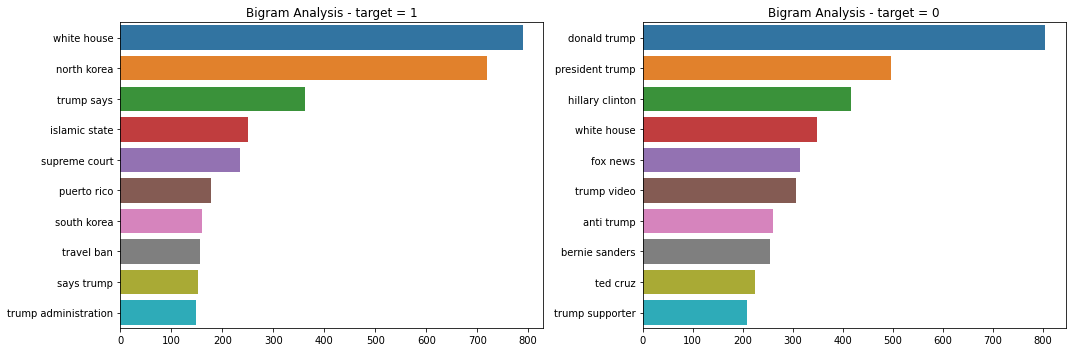

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
most_common_bigram_1 = dict(get_ngrams(df[df['target'] == 1]["clean_joined_title"], 10, 2))
sns.barplot(x=list(most_common_bigram_1.values()), y=list(most_common_bigram_1.keys()))
plt.title("Bigram Analysis - target = 1")

plt.subplot(1, 2, 2)
most_common_bigram_0 = dict(get_ngrams(df[df['target'] == 0]["clean_joined_title"], 10, 2))
sns.barplot(x=list(most_common_bigram_0.values()), y=list(most_common_bigram_0.keys()))
plt.title("Bigram Analysis - target = 0")

plt.tight_layout()
plt.show()

Most common tri grams in real news:  {'white house says': 86, 'house speaker ryan': 76, 'factbox trump twitter': 72, 'iran nuclear deal': 72, 'trump travel ban': 62, 'reuters ipsos poll': 56, 'highlights trump presidency': 46, 'south china sea': 44, 'says north korea': 35, 'north korea sanctions': 35}
Most common tri grams in fake news:  {'black lives matter': 163, 'new york times': 51, 'donald trump video': 48, 'fox news host': 47, 'supreme court justice': 47, 'trump campaign manager': 43, 'anti trump protesters': 35, 'patrick henningsen live': 30, 'episode sunday wire': 30, 'year old girl': 29}


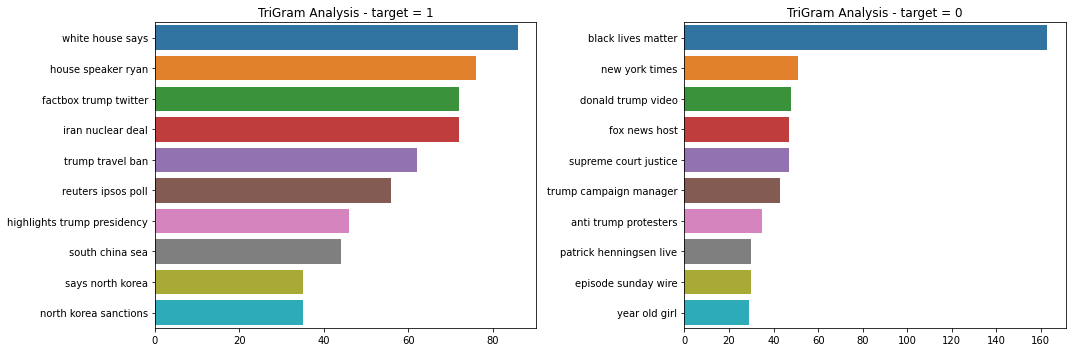

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
most_common_trigram_1 = dict(get_ngrams(df[df['target'] == 1]["clean_joined_title"], 10, 3))
sns.barplot(x=list(most_common_trigram_1.values()), y=list(most_common_trigram_1.keys()))
plt.title("TriGram Analysis - target = 1")
print("Most common tri grams in real news: ", most_common_trigram_1)
plt.subplot(1, 2, 2)
most_common_trigram_0 = dict(get_ngrams(df[df['target'] == 0]["clean_joined_title"], 10, 3))
sns.barplot(x=list(most_common_trigram_0.values()), y=list(most_common_trigram_0.keys()))
plt.title("TriGram Analysis - target = 0")
print("Most common tri grams in fake news: ", most_common_trigram_0)

plt.tight_layout()
plt.show()

C:\Users\Checkout\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Checkout\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



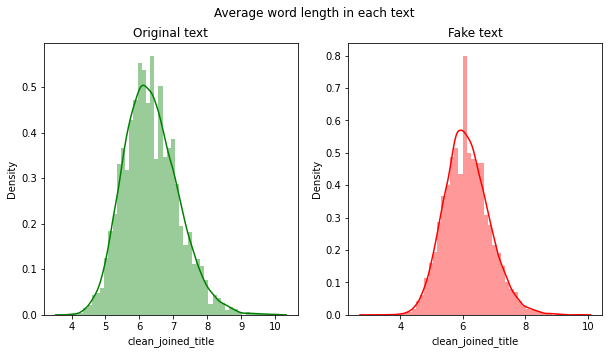

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

word = df[df['target'] == 1]['clean_joined_title'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color='green')
ax1.set_title('Original text')

word = df[df['target'] == 0]['clean_joined_title'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color='red')
ax2.set_title('Fake text')

fig.suptitle('Average word length in each text')
plt.show();

In [27]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format="%B %d, %Y",errors='coerce')


In [28]:
df['date'].value_counts()

2017-05-10    46
2016-05-26    44
2016-05-05    44
2016-05-06    44
2016-05-11    43
              ..
2017-10-09     1
2017-11-20     1
2017-11-19     1
2017-10-22     1
2017-12-04     1
Name: date, Length: 757, dtype: int64

In [29]:

# Extract the month, day, and year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

# Group by month, day, and year and count the occurrences of fake news
fake_news_counts_month = df[df['target'] == 0]['month'].value_counts()
fake_news_counts_day = df[df['target'] == 0]['day'].value_counts()
fake_news_counts_year = df[df['target'] == 0]['year'].value_counts()

# Print the insights
print("Fake News Published by Month:")
print(fake_news_counts_month)
print("\nFake News Published by Day:")
print(fake_news_counts_day)
print("\nFake News Published by Year:")
print(fake_news_counts_year)

Fake News Published by Month:
5.0     2177
1.0     1275
3.0     1220
2.0     1154
4.0      972
6.0      876
7.0      777
8.0      751
10.0     718
9.0      713
11.0     655
12.0     580
Name: month, dtype: int64

Fake News Published by Day:
6.0     439
10.0    436
5.0     431
9.0     429
7.0     419
12.0    416
1.0     412
11.0    412
8.0     410
3.0     408
13.0    406
17.0    405
15.0    395
16.0    390
22.0    389
2.0     386
4.0     384
21.0    381
14.0    379
19.0    376
18.0    374
20.0    372
26.0    367
23.0    365
27.0    362
28.0    356
29.0    354
25.0    346
24.0    332
30.0    309
31.0    228
Name: day, dtype: int64

Fake News Published by Year:
2016.0    7077
2017.0    4453
2015.0     338
Name: year, dtype: int64


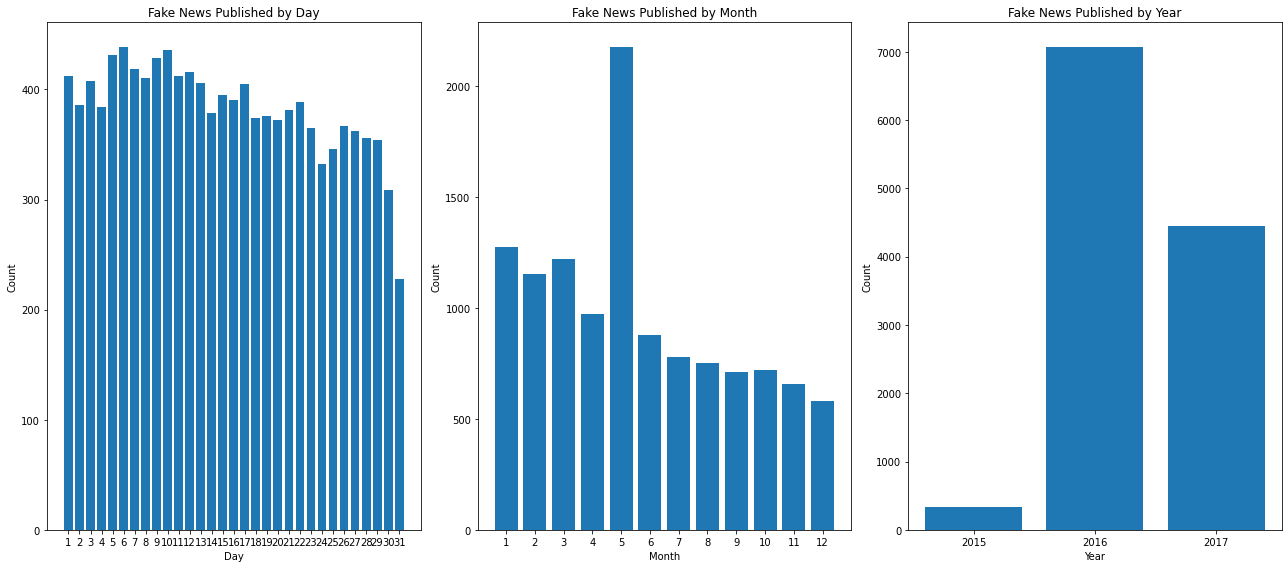

In [30]:
# Plotting value counts of month and year
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plotting month
axes[0].bar(fake_news_counts_day.index, fake_news_counts_day.values)
axes[0].set_xticks(fake_news_counts_day.index)
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Count')
axes[0].set_title('Fake News Published by Day')

# Plotting month
axes[1].bar(fake_news_counts_month.index, fake_news_counts_month.values)
axes[1].set_xticks(fake_news_counts_month.index)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_title('Fake News Published by Month')

# Plotting year
axes[2].bar(fake_news_counts_year.index, fake_news_counts_year.values)
axes[2].set_xticks(fake_news_counts_year.index)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Count')
axes[2].set_title('Fake News Published by Year')

plt.tight_layout()
plt.show()

In [31]:
from gensim.models import Word2Vec

corpus = [text.split() for text in df['clean_joined_title']]
emb_size = 100
# Train Word2Vec model
model_w2v = Word2Vec(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

In [32]:
meta_text_vec = []
for text in df['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_w2v.wv:
            vec += model_w2v.wv[token]
    meta_text_vec.append(vec)
meta_text_vec = np.array(meta_text_vec)
meta_text_vec.shape

(44898, 100)

In [33]:
words = model_w2v.wv.index_to_key
# words,len(words)

In [34]:
df_embed = pd.DataFrame(meta_text_vec,columns = ['embed_{}'.format(i) for i in range(meta_text_vec.shape[1])])
final_df = pd.concat([df_embed, df[['target']]],axis = 1)
final_df.head()

embed_0    embed_1    embed_2     embed_3    embed_4    embed_5  \
0  25.640369  87.197333 -15.662246  122.064918 -66.249564 -57.630253   
1  22.277971  77.236114 -12.301562   91.965391 -34.810991 -53.607391   
2  20.235697  49.649102  -5.699759   75.280092 -24.196101 -33.682790   
3  13.885738  35.798044  -3.898067   51.822783 -16.106868 -22.439545   
4  25.221326  76.743026 -12.131370  103.487731 -47.016732 -51.770796   

     embed_6    embed_7     embed_8    embed_9  ...    embed_91   embed_92  \
0  38.864884  76.525597 -100.898022 -61.116826  ...  122.182506  15.286684   
1  26.315557  80.488883  -86.479158 -67.868169  ...   85.527582  11.052317   
2  15.683505  48.617417  -59.877858 -34.347402  ...   61.054323  12.549885   
3  10.873502  33.581355  -41.087109 -24.090134  ...   39.929814   8.244673   
4  29.176502  73.790920  -88.934170 -55.732597  ...   98.189020  15.958531   

    embed_93    embed_94   embed_95   embed_96   embed_97   embed_98  \
0  48.146807  165.070355  45.135109 -78.077942 -51.149618  23.343355   
1  36.321583  138.308013  55.140787 -40.690834 -58.971996  23.461713   
2  29.126903   88.485974  30.731464 -39.375148 -31.096433  12.154500   
3  18.682778   62.677659  21.538524 -24.600488 -21.214380  10.020931   
4  45.255492  141.185752  47.361489 -62.152667 -49.962816  17.027704   

    embed_99  target  
0 -27.694764       1  
1 -30.810270       1  
2 -10.819659       1  
3  -8.506913       1  
4 -19.188559       1  

[5 rows x 101 columns]

In [35]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from random import randint
import warnings
warnings.filterwarnings("ignore")
classifiers = {'Logistic': LogisticRegression(max_iter=1000),
               'KNN': KNeighborsClassifier(),
               'RandomForest':RandomForestClassifier(),
               'XGBOOST': xgb.XGBClassifier(n_estimators=300, random_state=0)}


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te
data_bc = final_df.drop(columns='target')
label_bc = final_df['target']
X_train, X_test, y_train, y_test = split(data_bc, label_bc)

for key in classifiers:
    classifiers[key].fit(X_train, y_train)
    y_pred = classifiers[key].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {key}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")
    print()


Model: Logistic
Accuracy: 0.8653006681514477
Precision: 0.8672465960665658
Recall: 0.8498888065233506
F1 score: 0.8584799700486709

Model: KNN
Accuracy: 0.761336302895323
Precision: 0.7647632040537907
Recall: 0.7272053372868792
F1 score: 0.7455115417497862

Model: RandomForest
Accuracy: 0.8401781737193764
Precision: 0.8425256751616584
Recall: 0.8209785025945144
F1 score: 0.8316125398911207

[14:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBOOST
Accuracy: 0.8529175946547884
Precision: 0.859612060687536
Recall: 0.8295033358042995
F1 score: 0.8442893520701689



In [37]:
import shap

# Create a SHAP explainer object for the logistic regression model
lr_explainer = shap.LinearExplainer(classifiers['Logistic'], X_train)


In [38]:
# Compute SHAP values for a sample of the test data
lr_shap_values = lr_explainer.shap_values(X_test)

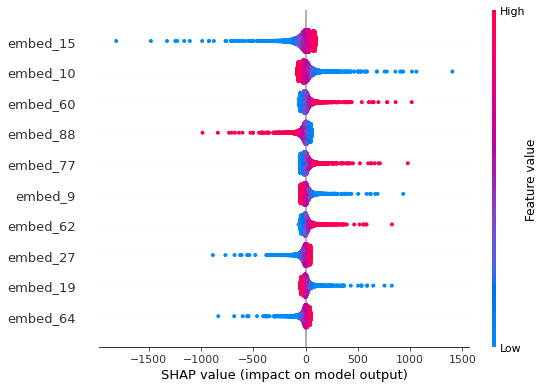

In [39]:
# Visualize the SHAP values for the logistic regression model
shap.summary_plot(lr_shap_values, X_test,max_display =10)

In [40]:
xgb_explainer = shap.Explainer(classifiers['XGBOOST'])
xgb_shap_values = xgb_explainer(X_test)


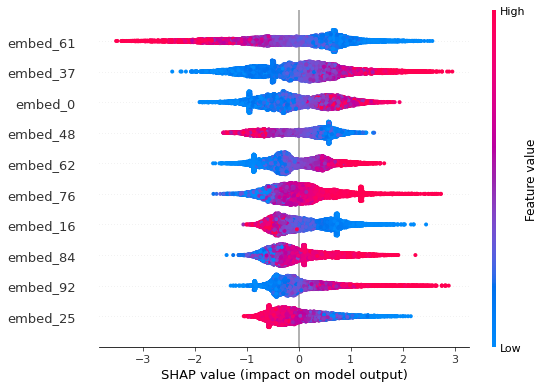

In [41]:
shap.summary_plot(xgb_shap_values, X_test,max_display =10)


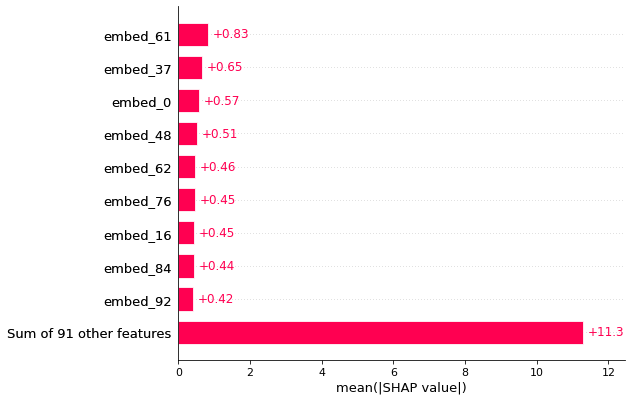

In [42]:
# Create SHAP positive/negative impact plot
shap.plots.bar(xgb_explainer(X_test))

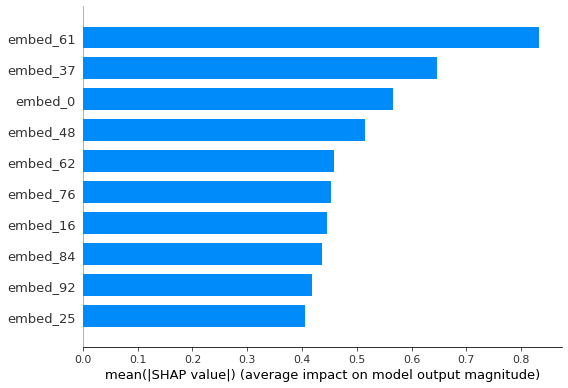

In [43]:
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar",max_display =10)


### CNN-LSTM training

In [44]:
# feature extraction using Word2Vec
sentences = [nltk.word_tokenize(text) for text in df['clean_joined_title']]
word2vec_model = Word2Vec(sentences, vector_size=100, min_count=1)
# create embeddings
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
tf.compat.v1.enable_eager_execution()


Using TensorFlow backend.


In [46]:
vocabulary_size = len(word2vec_model.wv.key_to_index)

tokenizer = Tokenizer(num_words= vocabulary_size, lower=True, char_level=False)
tokenizer.fit_on_texts(df['clean_joined_title'].values)
sequences = tokenizer.texts_to_sequences(df['clean_joined_title'].values)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

embedding_matrix = np.zeros((vocabulary_size + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.key_to_index:
        embedding_matrix[i] = word2vec_model.wv[word]


In [47]:
# model training
X_train, X_test, y_train, y_test = train_test_split(data, df['target'], test_size=0.2, random_state=42)


In [48]:
input_tensor = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = tf.keras.layers.Embedding(vocabulary_size+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)(input_tensor)
dropout_layer = tf.keras.layers.Dropout(0.2)(embedding_layer)
conv1d_layer = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(dropout_layer)
maxpooling1d_layer = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1d_layer)
lstm_layer = tf.keras.layers.LSTM(100)(maxpooling1d_layer)
output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_layer)

cnn_lstm_model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)
cnn_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [49]:
X_train,y_train

(array([[    0,     0,     0, ...,  2404,  2052,   989],
        [    0,     0,     0, ...,  2558,    75,    53],
        [    0,     0,     0, ...,  2931,    41, 12649],
        ...,
        [    0,     0,     0, ...,  2189,  2303,  7536],
        [    0,     0,     0, ...,   876,   435,  5357],
        [    0,     0,     0, ...,  2995,   154,  5544]]),
 36335    0
 12384    1
 24419    0
 24740    0
 27039    0
         ..
 11284    1
 44732    0
 38158    0
 860      1
 15795    1
 Name: target, Length: 35918, dtype: int64)

In [51]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
history = cnn_lstm_model.fit(X_train, np.array(y_train), epochs=10, batch_size=256,
#                                callbacks = [early_stopping],
                             validation_split = 0.2)


Train on 28734 samples, validate on 7184 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
28734/28734 [==============================] - 38s 1ms/sample - loss: 0.4435 - acc: 0.7792 - val_loss: 0.3736 - val_acc: 0.8305
Epoch 2/10
28734/28734 [==============================] - 28s 972us/sample - loss: 0.3708 - acc: 0.8288 - val_loss: 0.3450 - val_acc: 0.8487
Epoch 3/10
28734/28734 [==============================] - 31s 1ms/sample - loss: 0.3410 - acc: 0.8470 - val_loss: 0.3170 - val_acc: 0.8590
Epoch 4/10
28734/28734 [==============================] - 28s 973us/sample - loss: 0.3294 - acc: 0.8513 - val_loss: 0.3094 - val_acc: 0.8629
Epoch 5/10
28734/28734 [==============================] - 32s 1ms/sample - loss: 0.3156 - acc: 0.8593 - val_loss: 0.2956 - val_acc: 0.8717
Epoch 6/10
28734/28734 [==============================] - 32s 1ms/sample - loss: 0.3097 - acc: 0.8630 - val_loss: 0.2887 - val_acc: 0.8717
Epoch 7/10
28734/28

In [52]:
# cnn_lstm_model.save('lstm_model.pb')

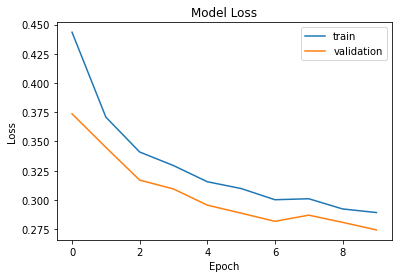

In [53]:
# Plotting train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [54]:

y_pred_prob = cnn_lstm_model.predict(X_test)

# Get the class labels as integers
# y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = [1 if each > 0.5 else 0 for each in y_pred_prob ]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.879955456570156
Precision: 0.8352577319587629
Recall: 0.9355658198614318
F1 Score: 0.8825708061002178
